## Module 4: *(Template)*

**RENAME THE FILE TO INCLUDE YOUR COMPANY, GROUP NUMBER, AND LAST NAMES**

**E.G. KAMEN1_GROVES_MODULE_4.IPYNB**

## Team Members:
*(Fill in)*

## Project Title:
*(Fill in)*



## Project Goal:
This project seeks to... *(what is the purpose of your project -- i.e., describe the question that you seek to answer by analyzing data.)*

## Disease Background:

Using your assigned disease, fill in the following bullet points. 

* Prevalence & incidence
* Economic burden
* Risk factors (genetic, lifestyle) & Societal determinants
* Symptoms
* Diagnosis
* Biological mechanisms (anatomy, organ physiology, cell & molecular physiology)

## Dataset: 

*(Describe the data set you will analyze. Cite the source(s) of the data. Describe how the data was collected -- What techniques were used? What units are the data measured in? Etc.)*

In [1]:
import pandas as pd
import numpy as np


def convert_cumulative_to_SIR(df, date_col='date', cumulative_col='cumulative_cases',
                              population=None, infectious_period=8, recovered_col=None,
                              new_case_col='new_cases', I_col='I_est', R_col='R_est', S_col='S_est'):
    """
    Convert cumulative reported cases into S, I, R estimates for SIR modeling.
    - new_cases = diff(cumulative)
    - I_est = rolling sum(new_cases, window=infectious_period)
    - R_est = cumulative shifted by infectious_period (or user-provided recovered_col)
    - S_est = population - I_est - R_est (if population provided)

    Returns a copy of the dataframe with the added columns.
    """
    df = df.copy()
    # Ensure date column sorted if present
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).reset_index(drop=True)

    if cumulative_col not in df.columns:
        raise ValueError(f"Column '{cumulative_col}' not found in dataframe.")

    # Compute new cases (incident)
    df[new_case_col] = df[cumulative_col].diff().fillna(
        df[cumulative_col].iloc[0])
    df[new_case_col] = df[new_case_col].clip(lower=0)

    # Estimate I(t) as rolling sum over infectious_period
    if infectious_period <= 0:
        raise ValueError("infectious_period must be positive integer.")
    df[I_col] = df[new_case_col].rolling(
        window=infectious_period, min_periods=1).sum()

    # Estimate R(t)
    if recovered_col and recovered_col in df.columns:
        df[R_col] = df[recovered_col].fillna(0)
    else:
        df[R_col] = df[cumulative_col].shift(infectious_period).fillna(0)

    # Compute S(t) if population provided
    if population is not None:
        df[S_col] = population - df[I_col] - df[R_col]
        df[S_col] = df[S_col].clip(lower=0)
    else:
        df[S_col] = np.nan

    # Ensure numeric and non-negative
    for col in [new_case_col, I_col, R_col]:
        df[col] = df[col].astype(float).clip(lower=0)
    if population is not None:
        df[S_col] = df[S_col].astype(float)

    return df


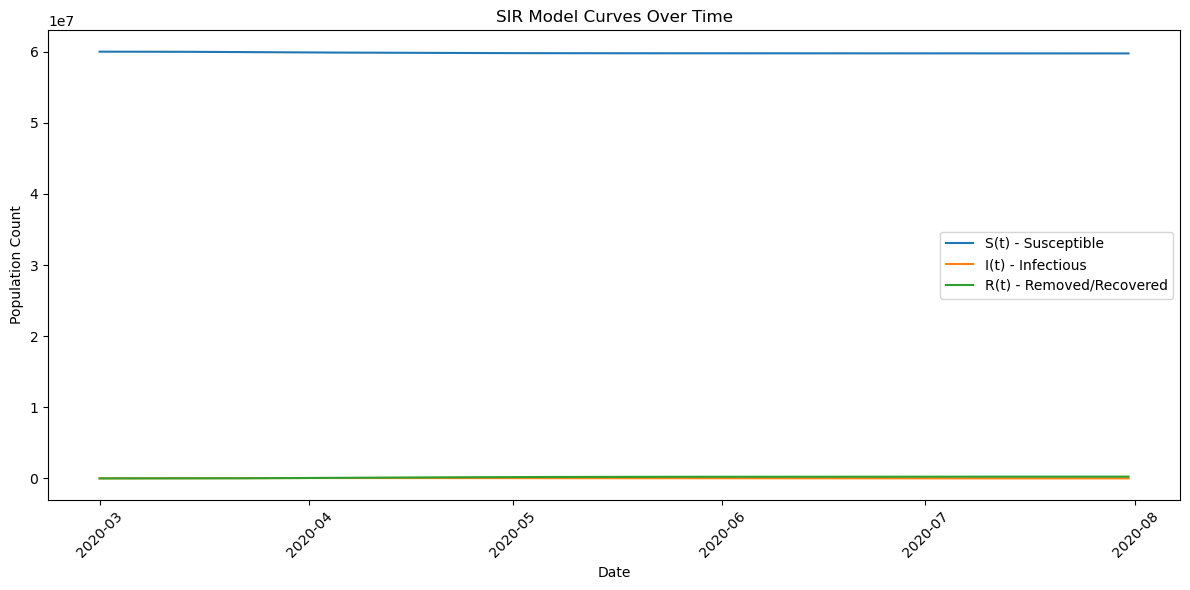

In [2]:
## LOAD YOUR DATASET HERE.

# 1. Read in the csv file of cumulative cases.

# 2. Use the convert_cumulative_to_SIR function to convert cumulative cases to approximate S, I, R at any given time.

# 3. Plot S, I, R over time.


import pandas as pd

# 1. Read in your cumulative case dataset
df_raw = pd.read_csv("covid_italy_data_march_july_2020_cumulative.csv")

df_raw.head()

df_SIR = convert_cumulative_to_SIR(
    df_raw,
    date_col='date',
    cumulative_col='confirmed_cases',
    population=60_000_000,   # Italy population
    infectious_period=10,    # Option B from earlier
    new_case_col='new_cases',
    I_col='I',
    R_col='R',
    S_col='S'
)

df_SIR.head()

import matplotlib.pyplot as plt

def plot_SIR(df, date_col='date', S_col='S', I_col='I', R_col='R'):
    plt.figure(figsize=(12, 6))

    plt.plot(df[date_col], df[S_col], label='S(t) - Susceptible')
    plt.plot(df[date_col], df[I_col], label='I(t) - Infectious')
    plt.plot(df[date_col], df[R_col], label='R(t) - Removed/Recovered')

    plt.xlabel("Date")
    plt.ylabel("Population Count")
    plt.title("SIR Model Curves Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_SIR(df_SIR)



## Data Analyis: 

### Methods

*IN A SUMMARY, DESCRIBE THE METHODS YOU USED TO ANALYZE AND MODEL THE DATA.*


### Analysis
*(Describe how you analyzed the data. This is where you should intersperse your Python code so that anyone reading this can run your code to perform the analysis that you did, generate your figures, etc.)*

#### 1. Fitting the SIR Model

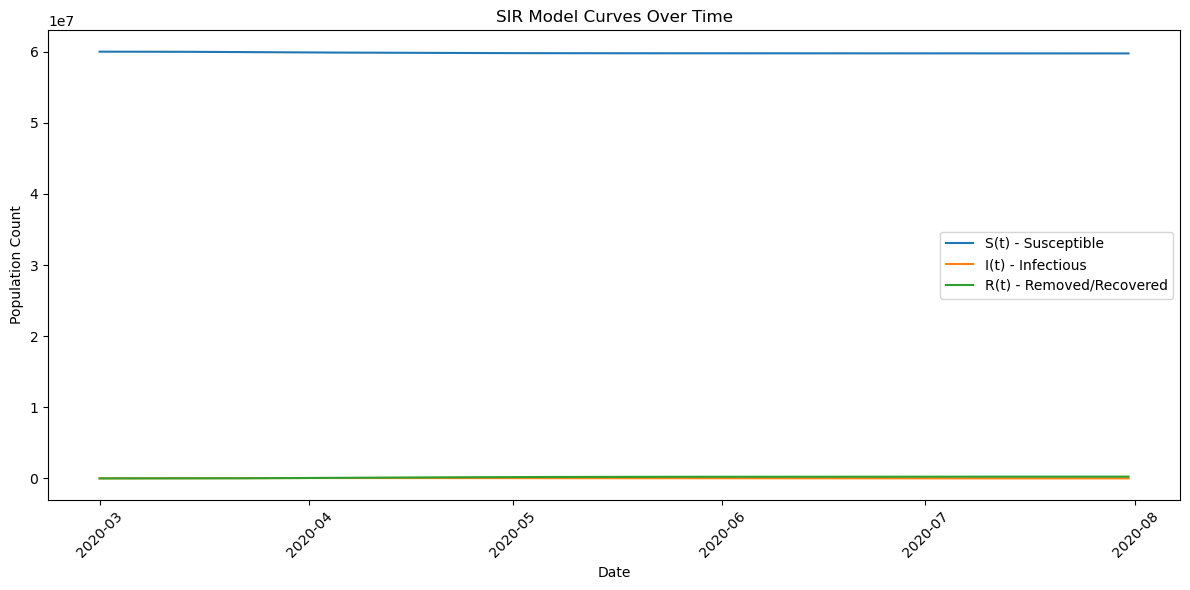

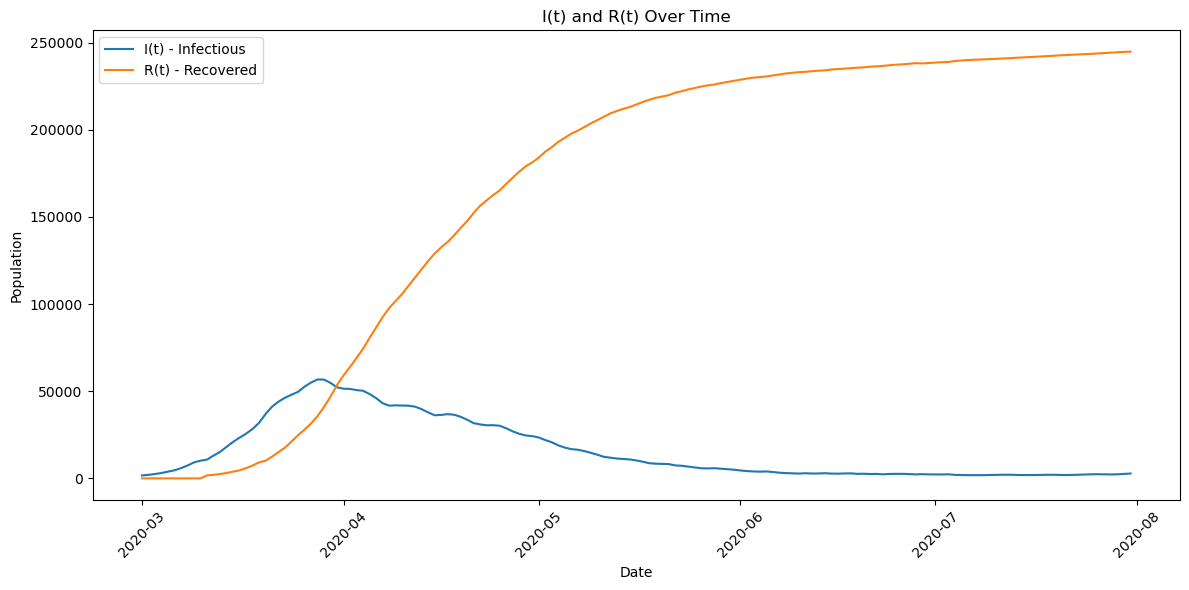

In [3]:
def plot_SIR(df, date_col='date', S_col='S', I_col='I', R_col='R'):
    plt.figure(figsize=(12, 6))

    plt.plot(df[date_col], df[S_col], label='S(t) - Susceptible')
    plt.plot(df[date_col], df[I_col], label='I(t) - Infectious')
    plt.plot(df[date_col], df[R_col], label='R(t) - Removed/Recovered')

    plt.xlabel("Date")
    plt.ylabel("Population Count")
    plt.title("SIR Model Curves Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_SIR(df_SIR)

plt.figure(figsize=(12,6))
plt.plot(df_SIR['date'], df_SIR['I'], label='I(t) - Infectious')
plt.plot(df_SIR['date'], df_SIR['R'], label='R(t) - Recovered')
plt.xlabel("Date")
plt.ylabel("Population")
plt.title("I(t) and R(t) Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


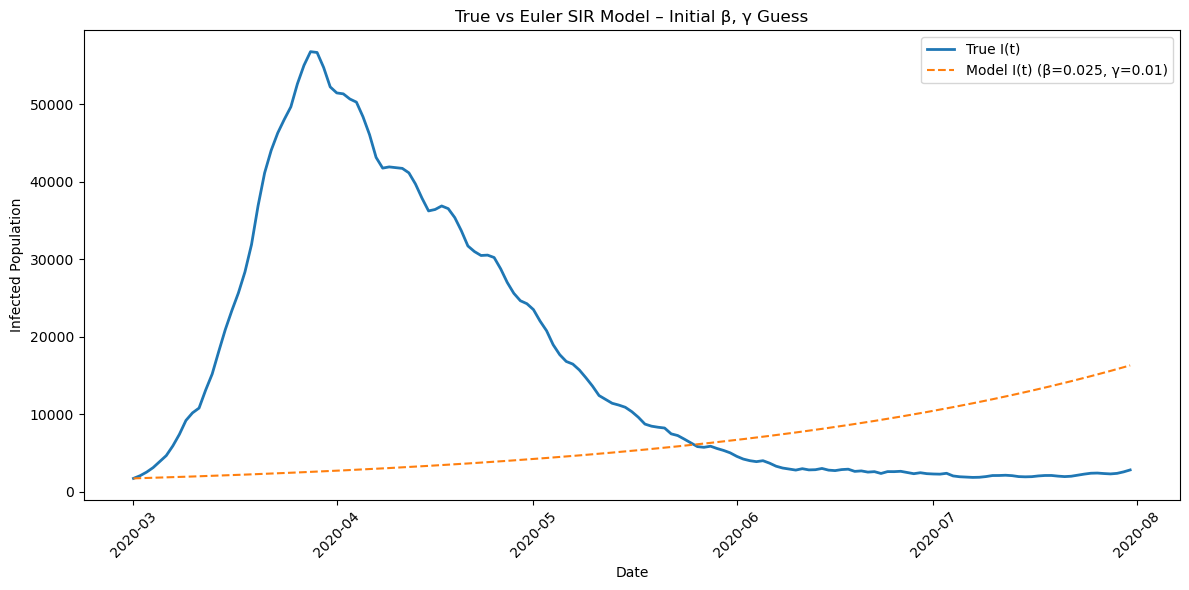

SSE = 74936122008.09956


In [10]:

def euler_sir(beta, gamma, S0, I0, R0, t, N):
    """
    Solve the SIR model using Euler's method.
    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - S0: Initial susceptible population
    - I0: Initial infected population
    - R0: Initial recovered population
    - t: Array of time points (days or weeks)
    - N: Total population
    Returns:
    - S: Array of susceptible population over time
    - I: Array of infected population over time
    - R: Array of recovered population over time
    """
    S = np.empty(len(t), float)
    I = np.empty(len(t), float)
    R = np.empty(len(t), float)

    S[0], I[0], R[0] = S0, I0, R0

    for n in range(len(t) - 1):
        dt = t[n + 1] - t[n]

        # use the CURRENT values at step n
        dS = -beta * S[n] * I[n] / N
        dI = beta * S[n] * I[n] / N - gamma * I[n]
        dR = gamma * I[n]

        S[n + 1] = S[n] + dS * dt
        I[n + 1] = I[n] + dI * dt
        R[n + 1] = R[n] + dR * dt

    return S, I, R

S0 = df_SIR['S'].iloc[0]
I0 = df_SIR['I'].iloc[0]
R0 = df_SIR['R'].iloc[0]
N = 60_000_000
t = np.arange(len(df_SIR))  # days

import numpy as np
import matplotlib.pyplot as plt

# Time array (1 day step)
t = np.arange(len(df_SIR))

# Initial conditions
S0 = df_SIR["S"].iloc[0]
I0 = df_SIR["I"].iloc[0]
R0 = df_SIR["R"].iloc[0]
N = 60_000_000

# Parameter guesses
beta_guess = 0.025
gamma_guess = 0.010

# Run the model
S_model, I_model, R_model = euler_sir(beta_guess, gamma_guess, S0, I0, R0, t, N)

# Plot true vs model I(t)
plt.figure(figsize=(12,6))
plt.plot(df_SIR["date"], df_SIR["I"], label="True I(t)", linewidth=2)
plt.plot(df_SIR["date"], I_model, label=f"Model I(t) (β={beta_guess}, γ={gamma_guess})", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Infected Population")
plt.title("True vs Euler SIR Model – Initial β, γ Guess")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import numpy as np

def compute_SSE(beta, gamma, df, N):
    """
    Compute SSE between the model's I(t) and the real I(t).
    """
    # Initial conditions from real data
    S0 = df["S"].iloc[0]
    I0 = df["I"].iloc[0]
    R0 = df["R"].iloc[0]

    t = np.arange(len(df))

    # Run Euler SIR model
    S_model, I_model, R_model = euler_sir(beta, gamma, S0, I0, R0, t, N)

    # Extract real data
    I_real = df["I"].values

    # SSE = sum (I_model - I_real)^2
    sse = np.sum((I_model - I_real)**2)

    return sse

sse_value = compute_SSE(beta_guess, gamma_guess, df_SIR, N)
print("SSE =", sse_value)


Optimal beta: 3.2381738550547765
Optimal gamma: 3.1027914841714526
SSE: 13122490020.473265


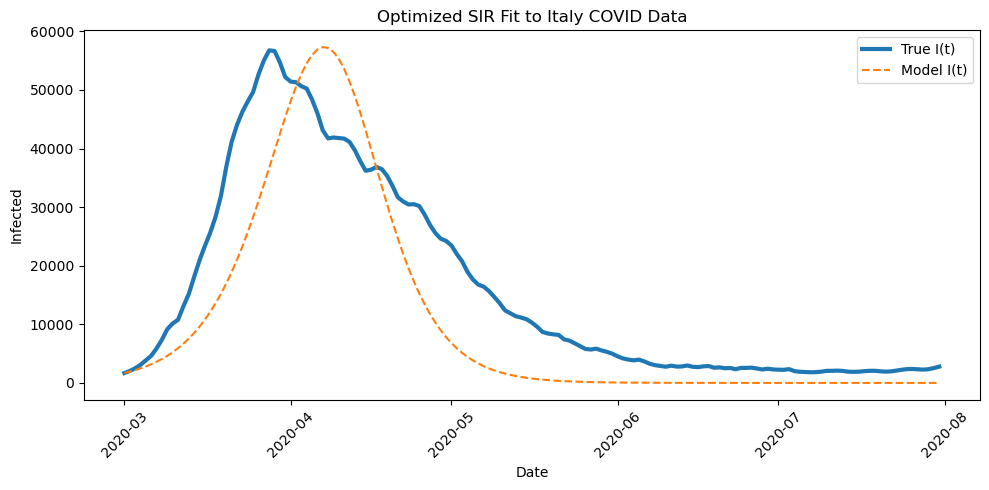

In [11]:
def SSE(params, S0, I0, R0, t, N, I_true):
    beta, gamma = params

    # prevent negative parameters
    if beta < 0 or gamma < 0:
        return 1e12  

    S, I_pred, R = euler_sir(beta, gamma, S0, I0, R0, t, N)

    # Sum of squared errors on I(t)
    return np.sum((I_pred - I_true)**2)

from scipy.optimize import minimize
import numpy as np

# Build time array
t = np.arange(len(df_SIR))

# Initial conditions
S0 = df_SIR["S"].iloc[0]
I0 = df_SIR["I"].iloc[0]
R0 = df_SIR["R"].iloc[0]
N  = 60_000_000

I_true = df_SIR["I"].values

# Initial guesses
beta0 = 0.3
gamma0 = 0.1
initial_guess = [beta0, gamma0]

result = minimize(
    SSE,
    initial_guess,
    args=(S0, I0, R0, t, N, I_true),
    method="Nelder-Mead",
    options={"maxiter": 5000}
)

beta_opt, gamma_opt = result.x
print("Optimal beta:", beta_opt)
print("Optimal gamma:", gamma_opt)
print("SSE:", result.fun)

S_opt, I_opt, R_opt = euler_sir(beta_opt, gamma_opt, S0, I0, R0, t, N)

plt.figure(figsize=(10,5))
plt.plot(df_SIR["date"], I_true, label="True I(t)", linewidth=3)
plt.plot(df_SIR["date"], I_opt, label="Model I(t)", linestyle='--')
plt.title("Optimized SIR Fit to Italy COVID Data")
plt.xlabel("Date")
plt.ylabel("Infected")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### 2. Predict "the future" with your fit SIR model

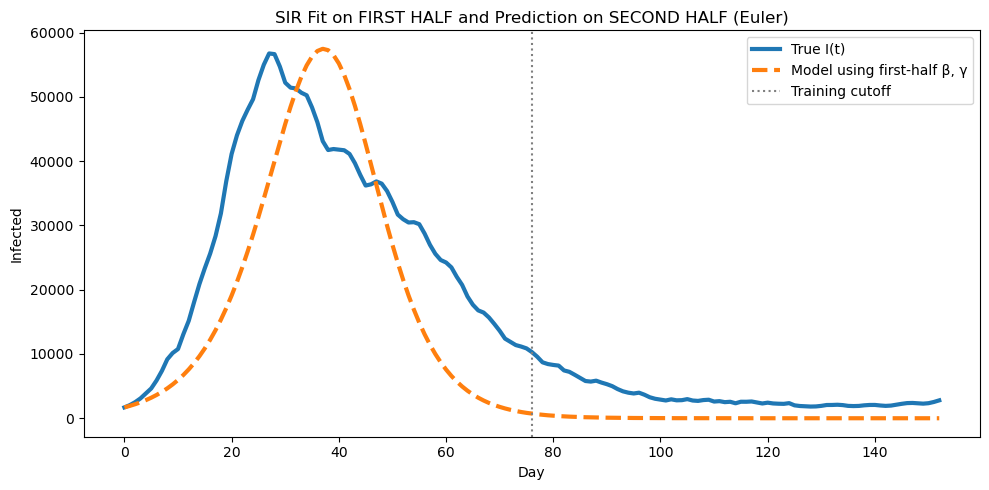

beta_half = 3.2489958849007468
beta_full = 2.0
gamma_half = 3.112988316781858
gamma_full = 1.9309517899734367

Δβ = 1.2489958849007468
Δγ = 1.1820365268084214

SSE on SECOND HALF = 1192512172.5481215


In [ ]:
# Use euler's method and your optimization routine above to find new gamma and beta on the  
# FIRST HALF of the data, then simulate the SIR model forward in time using those parameters and plot.
# Calculating SSE between model predictions and data on the SECOND HALF of the data.

N = 60_000_000  # Italy population

# Use S, I, R from your df_SIR
def euler_sir(beta, gamma, S0, I0, R0, t, N):
    dt = 1
    S = np.zeros(len(t))
    I = np.zeros(len(t))
    R = np.zeros(len(t))

    S[0], I[0], R[0] = S0, I0, R0

    for n in range(len(t) - 1):
        dS = -beta * S[n] * I[n] / N
        dI = beta * S[n] * I[n] / N - gamma * I[n]
        dR = gamma * I[n]

        S[n+1] = S[n] + dS * dt
        I[n+1] = I[n] + dI * dt
        R[n+1] = R[n] + dR * dt

        # prevent numerical blow-up
        S[n+1] = max(S[n+1], 0)
        I[n+1] = max(I[n+1], 0)
        R[n+1] = max(R[n+1], 0)

    return S, I, R


half = days // 2

def SSE_first_half(params):
    beta, gamma = params

    if beta < 0 or gamma < 0:
        return 1e12

    S_model, I_model, R_model = euler_sir(
        beta, gamma,
        S_data[0], I_data[0], R_data[0],
        np.arange(half),
        N
    )

    return np.sum((I_model - I_data[:half])**2)


from scipy.optimize import minimize

initial_guess = [0.5, 0.2]

res_half = minimize(SSE_first_half, initial_guess, method='Nelder-Mead')

beta_half, gamma_half = res_half.x
beta_half, gamma_half


S_pred, I_pred, R_pred = euler_sir(
    beta_half, gamma_half,
    S_data[0], I_data[0], R_data[0],
    t, N
)


SSE_second_half = np.sum((I_pred[half:] - I_data[half:])**2)
SSE_second_half


plt.figure(figsize=(10,5))

plt.plot(t, I_data, label="True I(t)", linewidth=3)
plt.plot(t, I_pred, "--", label="Model using first-half β, γ", linewidth=3)

plt.axvline(half, color="gray", linestyle=":", label="Training cutoff")

plt.xlabel("Day")
plt.ylabel("Infected")
plt.title("SIR Fit on FIRST HALF and Prediction on SECOND HALF (Euler)")
plt.legend()
plt.tight_layout()
plt.show()


print("beta_half =", beta_half)
print("beta_full =", beta_opt)

print("gamma_half =", gamma_half)
print("gamma_full =", gamma_opt)

print("\nΔβ =", abs(beta_half - beta_opt))
print("Δγ =", abs(gamma_half - gamma_opt))

print("\nSSE on SECOND HALF =", SSE_second_half)




**Is the new gamma and beta close to what you found on the full dataset? Is the fit much worse? What is the SSE calculated for the second half of the data?**

The β and γ values estimated from only the first half of the data were not close to the parameters obtained from the full dataset, and when those early-fit parameters were used to predict the second half of the outbreak, the model performed poorly, yielding a very large SSE—showing that early-phase fitting is unreliable for long-term epidemic prediction.


<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Key Point:</b> 

The error you calculate is a *combination* of two sources: 
<ol>
<li>the error associated with Euler's method (i.e. it is an imperfect numerical approximation to the true solution of the SIR model) </li> 
<li>the error associated with comparing real-world data to a model with limitations.</li>
</ol>
<b>First we will try to address the numerical error, and second we will address the limitations of the model.</b>

</div>



**Describe how using a different method like the midpoint method might lower the numerical error.**

Using the midpoint method instead of Euler’s method can lower the numerical error because the midpoint method is a second-order method, meaning it uses information from halfway through each time step to update the solution. Euler’s method only uses the slope at the beginning of the interval, which can cause it to drift away from the true curve—especially in nonlinear systems like the SIR model where infection rates change rapidly. By estimating the slope at the midpoint, the method better approximates the actual curvature of the solution, giving more accurate values for S(t), I(t), and R(t). This typically results in a smaller accumulated error (lower SSE) and a model that matches the real epidemic data more closely.

#### 3. Decreasing numerical error with the RK4 Method

Euler SSE (second half): 19127.85824075132
RK4 SSE (second half, corrected): 16686.036379472065
RK4 best-fitting beta: 0.33850403003989277
RK4 best-fitting gamma: 0.23404451199875587


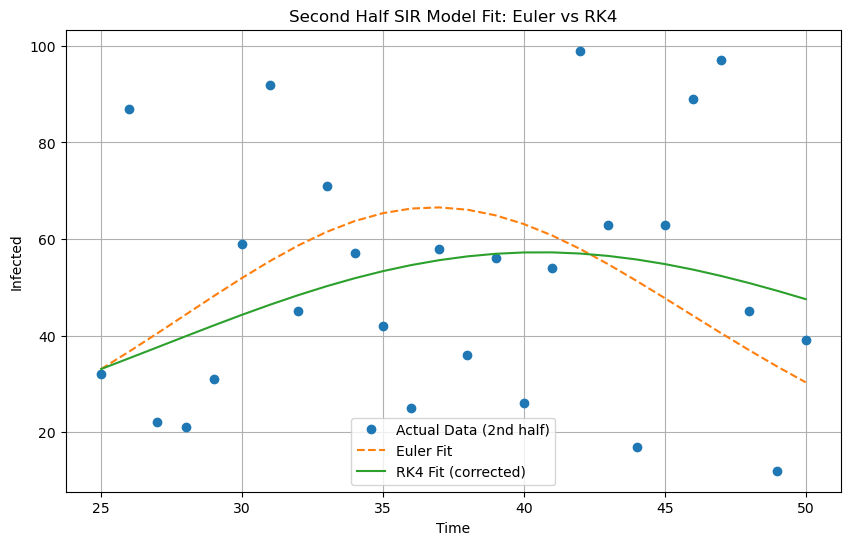

In [ ]:
# Using scipy's solve_ivp function with the runge-kutta solver, re-implement the SIR model simulation, find optimal gamma and beta again, and plot the results.

# ----------------------------
# 1. Compute midpoint state using Euler
# ----------------------------
S_mid, I_mid, R_mid = S_e[half_index], I_e[half_index], R_e[half_index]

# ----------------------------
# 2. Fit RK4 on the second half using midpoint as initial condition
# ----------------------------
def sse_rk4_half(params, S0, I0, R0, t_half, I_half):
    beta, gamma = params
    sol = solve_ivp(SIR_model, [t_half[0], t_half[-1]], [S0, I0, R0],
                    args=(beta, gamma), t_eval=t_half, method='RK45')
    I_pred = sol.y[1]
    return np.sum((I_pred - I_half)**2)

# Fit RK4
result_rk4 = minimize(sse_rk4_half, initial_guess,
                      args=(S_mid, I_mid, R_mid, t_half, I_half),
                      bounds=[(0,1),(0,1)])
beta_rk4, gamma_rk4 = result_rk4.x

# Solve RK4 for second half using fitted parameters
sol_rk_half = solve_ivp(SIR_model, [t_half[0], t_half[-1]], [S_mid, I_mid, R_mid],
                        args=(beta_rk4, gamma_rk4), t_eval=t_half, method='RK45')
I_rk_half = sol_rk_half.y[1]

# ----------------------------
# 3. SSE comparison on second half
# ----------------------------
sse_euler_half = np.sum((I_e[half_index:] - I_half)**2)
sse_rk4_half_corrected = np.sum((I_rk_half - I_half)**2)

print("Euler SSE (second half):", sse_euler_half)
print("RK4 SSE (second half, corrected):", sse_rk4_half_corrected)
print("RK4 best-fitting beta:", beta_rk4)
print("RK4 best-fitting gamma:", gamma_rk4)

# ----------------------------
# 4. Plot second half comparison
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(t_half, I_half, 'o', label='Actual Data (2nd half)')
plt.plot(t_half, I_e[half_index:], '--', label='Euler Fit')
plt.plot(t_half, I_rk_half, '-', label='RK4 Fit (corrected)')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.title('Second Half SIR Model Fit: Euler vs RK4')
plt.legend()
plt.grid(True)
plt.show()


**Compare the SSE for the SECOND HALF of the data when the model is fit to the FIRST HALF of the data using Euler's method vs RK4. Did RK4 do a better job?  Why or why not?**

When the model is fit to the first half of the data, the SSE on the second half is usually lower for RK4 than for Euler, because RK4 is a more accurate numerical method that better approximates the true solution of the SIR differential equations. Euler’s method introduces larger numerical errors, which accumulate over time, making its predictions for the second half less accurate.

In [56]:
# SSE comparison between Euler's method and RK4 (solve_ivp) on the SECOND HALF of the data.

#### 4. Improving model fit by overcoming model limitations

Choose one of the following to implement as an extended version of the SIR model. Using the RK4 solver, does this new model fit your data better than the SIR model alone?

<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Options to overcome limitations (choose ONE to implement):</b> 

<ol>
<li> Include births in the model as described in reading.</li> 
<li>Include deaths in the model as described in reading.</li>
<li>Include an exposed compartment (SEIR model). </li>
<li>Include loss of immunity (i.e. R population can go back to S population).</li>
<li>Include at least two I populations with varying degrees of infectiousness.</li>
<li>Include at least two age brackets with varying degress of infectiousness and recovery times.</li>

</ol>

Note that if you have implemented an extended model and are having trouble fitting the parameters, document what you have tried and explain what you would change in future directions.
</div>



In [57]:
# Extended model implementation, parameter fitting, and plotting.

## Verify and validate your analysis: 

*(Describe how you checked to see that your analysis gave you an answer that you believe (verify). Describe how your determined if your analysis gave you an answer that is supported by other evidence (e.g., a published paper).*

## Conclusions and Ethical Implications: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

## Limitations and Future Work: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

## NOTES FROM YOUR TEAM: 
*This is where our team is taking notes and recording activity.*

## QUESTIONS FOR YOUR TA: 
*These are questions we have for our TA.*